Epoch 0, Loss: 9.88059e-01
Epoch 500, Loss: 1.23224e-04
Epoch 1000, Loss: 6.09807e-05
Epoch 1500, Loss: 3.30195e-05
Epoch 2000, Loss: 1.90703e-05
Epoch 2500, Loss: 1.20205e-05
Epoch 3000, Loss: 8.68857e-06
Epoch 3500, Loss: 7.88834e-06
Epoch 4000, Loss: 3.36902e-06
Epoch 4500, Loss: 3.59616e-06
Training time: 116.07 seconds


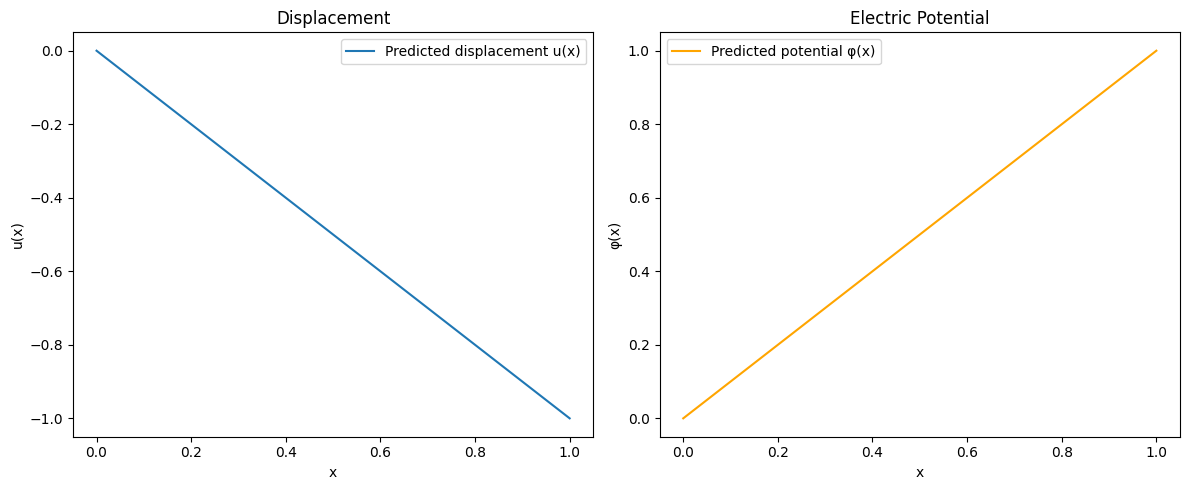

In [4]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt

# Configure TensorFlow to use 64-bit precision
tf.keras.backend.set_floatx("float64")

# Material properties (constants for simplicity)
c = 1.0       # Stiffness constant
e = 1.0       # Piezoelectric coupling constant
kappa = 1.0   # Dielectric permittivity constant

# Domain definition
L = 1.0       # Length of the domain
x_left = 0.0
x_right = L

# Boundary conditions
n_data_per_bc = 25  # Number of points per boundary condition

# Generate boundary condition points
x_bc_left = np.ones((n_data_per_bc, 1)) * x_left
x_bc_right = np.ones((n_data_per_bc, 1)) * x_right

# Boundary condition values
V0 = 1.0  # Applied voltage at x = L

# At x = 0: u(0) = 0, phi(0) = 0
u_bc_left = np.zeros((n_data_per_bc, 1))
phi_bc_left = np.zeros((n_data_per_bc, 1))

# At x = L: phi(L) = V0
phi_bc_right = np.ones((n_data_per_bc, 1)) * V0

# Collocation points
Nc = 1000
x_colloc = np.random.uniform(x_left, x_right, (Nc, 1))

# Convert to tensors
x_colloc = tf.convert_to_tensor(x_colloc, dtype=tf.float64)
x_bc_left = tf.convert_to_tensor(x_bc_left, dtype=tf.float64)
x_bc_right = tf.convert_to_tensor(x_bc_right, dtype=tf.float64)
u_bc_left = tf.convert_to_tensor(u_bc_left, dtype=tf.float64)
phi_bc_left = tf.convert_to_tensor(phi_bc_left, dtype=tf.float64)
phi_bc_right = tf.convert_to_tensor(phi_bc_right, dtype=tf.float64)

# Neural network model
def DNN_builder(in_shape=1, out_shape=2, n_hidden_layers=5, neuron_per_layer=20, actfn="tanh"):
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for _ in range(n_hidden_layers - 1):
        hidden.append(tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(hidden[-1]))
    output_layer = tf.keras.layers.Dense(out_shape, activation=None)(hidden[-1])
    model = tf.keras.Model(input_layer, output_layer)
    return model

tf.keras.backend.clear_session()
model = DNN_builder()

# Functions to compute u(x) and phi(x)
@tf.function
def u_phi(x):
    output = model(x)
    u = output[:, 0:1]
    phi = output[:, 1:2]
    return u, phi

# Corrected PDE residual function
@tf.function
def pde_residual(x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u, phi = u_phi(x)
        # First-order derivatives
        du_dx = tape.gradient(u, x)
        dphi_dx = tape.gradient(phi, x)
        # Compute E, sigma, and D
        E = -dphi_dx
        sigma = c * du_dx - e * E
        D = e * du_dx + kappa * E
        # Second-order derivatives
        d_sigma_dx = tape.gradient(sigma, x)
        d_D_dx = tape.gradient(D, x)
    residual_mech = d_sigma_dx
    residual_elec = d_D_dx
    return residual_mech, residual_elec

# Loss function
@tf.function
def loss_function():
    # Collocation points loss
    residual_mech, residual_elec = pde_residual(x_colloc)
    loss_pde_mech = tf.reduce_mean(tf.square(residual_mech))
    loss_pde_elec = tf.reduce_mean(tf.square(residual_elec))

    # Boundary conditions loss
    # At x = 0
    u_left, phi_left = u_phi(x_bc_left)
    loss_u_bc_left = tf.reduce_mean(tf.square(u_left - u_bc_left))
    loss_phi_bc_left = tf.reduce_mean(tf.square(phi_left - phi_bc_left))

    # At x = L
    _, phi_right = u_phi(x_bc_right)
    loss_phi_bc_right = tf.reduce_mean(tf.square(phi_right - phi_bc_right))

    # Stress-free boundary at x = L
    with tf.GradientTape() as tape:
        tape.watch(x_bc_right)
        u_right, _ = u_phi(x_bc_right)
    du_dx_right = tape.gradient(u_right, x_bc_right)
    with tf.GradientTape() as tape_phi:
        tape_phi.watch(x_bc_right)
        _, phi_right = u_phi(x_bc_right)
    dphi_dx_right = tape_phi.gradient(phi_right, x_bc_right)
    E_right = -dphi_dx_right
    sigma_right = c * du_dx_right - e * E_right
    loss_sigma_bc_right = tf.reduce_mean(tf.square(sigma_right))

    # Total loss
    loss = (loss_pde_mech + loss_pde_elec +
            loss_u_bc_left + loss_phi_bc_left +
            loss_phi_bc_right + loss_sigma_bc_right)
    return loss

# Training
epochs = 5000
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_values = []

start_time = time.time()
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_function()
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    loss_values.append(loss.numpy())
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.5e}")

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# Plotting results
x_plot = np.linspace(x_left, x_right, 100).reshape(-1, 1)
x_plot_tf = tf.convert_to_tensor(x_plot, dtype=tf.float64)
u_pred, phi_pred = u_phi(x_plot_tf)
u_pred = u_pred.numpy()
phi_pred = phi_pred.numpy()

plt.figure(figsize=(12, 5))

# Displacement plot
plt.subplot(1, 2, 1)
plt.plot(x_plot, u_pred, label='Predicted displacement u(x)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Displacement')

# Electric potential plot
plt.subplot(1, 2, 2)
plt.plot(x_plot, phi_pred, label='Predicted potential φ(x)', color='orange')
plt.xlabel('x')
plt.ylabel('φ(x)')
plt.legend()
plt.title('Electric Potential')

plt.tight_layout()
plt.show()
